In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Карты
import geopandas as gpd
import folium

%matplotlib inline

In [2]:
matplotlib.rcParams['figure.figsize'] = (15, 8) # делаем рисунки нормальных размеров
sns.set_style('whitegrid') # и делаем нормальный фон

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
data = pd.read_csv('spb_project_data.csv')
data.shape

(1484, 45)

In [5]:
# Смотрим на данные
data.head(10)

,price,rooms,metro,metro_time,description,address,Общая,Жилая,Кухня,Этаж,Построен,Можно с детьми,Холодильник,Посудомоечная машина,Стиральная машина,Мебель в комнатах,Мебель на кухне,Кондиционер,Телевизор,Интернет,Ванна,Планировка,Высота потолков,Санузел,Ванная комната,Балкон/лоджия,Ремонт,Вид из окон,Лифты,Аварийность,Парковка,Мусоропровод,Газоснабжение,lat,lng,URL,Год постройки,Строительная серия,Тип дома,Тип перекрытий,Подъезды,Отопление,Душевая кабина,Можно с животными,Тип жилья
0,37 000 ₽/мес.,"2-комн. квартира, 44,1 м²",Ленинский проспект,⋅ 11 мин. пешком,Сдаётся квартира на длительный период в 10 мин...,"Санкт-Петербург, р-н Кировский, Княжево, просп...","44,1 м²",23 м²,9 м²,4 из 21,2013.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Смежно-изолированная,"2,8 м",1 раздельный,Есть,"1 балкон, 1 лоджия",Дизайнерский,На улицу,"1 пасс., 1 груз.",Нет,Наземная,Нет,Автономное,59.850952,30.281418,https://spb.cian.ru/rent/flat/246712086/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14 000 ₽/мес.,"1-комн. квартира, 33 м²",NaN,NaN,"Сдается на длительный срок 1 комн. квартира, п...","Санкт-Петербург, р-н Красносельский, мкр. Крас...",33 м²,18 м²,7 м²,6 из 9,1975.0,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1 совмещенный,Есть,1 балкон,Косметический,Во двор,Есть,Нет,NaN,Есть,Центральное,59.721511,30.076242,https://spb.cian.ru/rent/flat/246711397/,1975.0,1-528КП,Кирпичный,Железобетонные,4.0,Центральное,NaN,NaN,NaN
2,25 000 ₽/мес.,"2-комн. квартира, 44,7 м²",Пионерская,⋅ 15 мин. пешком,"Сдается 2х комнатная квартира, от собственника...","Санкт-Петербург, р-н Приморский, Комендантский...","44,7 м²",27 м²,6 м²,4 из 9,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,Изолированная,NaN,1 раздельный,Есть,1 лоджия,Косметический,Во двор,Есть,Нет,NaN,Есть,NaN,60.006345,30.278911,https://spb.cian.ru/rent/flat/246711314/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20 000 ₽/мес.,"1-комн. квартира, 35 м²",Звездная,⋅ 25 мин. пешком,"Сдается на долгий срок, светлая и теплая кварт...","Санкт-Петербург, р-н Московский, Звёздное, про...",35 м²,"15,4 м²","9,6 м²",14 из 18,2019.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1 совмещенный,NaN,1 лоджия,Евроремонт,На улицу,"1 пасс., 1 груз.",Нет,Наземная,NaN,NaN,59.819382,30.340976,https://spb.cian.ru/rent/flat/246709991/,2019.0,NaN,NaN,Железобетонные,5.0,NaN,1.0,NaN,NaN
4,22 000 ₽/мес.,"Студия, 22 м²",Удельная,⋅ 10 мин. пешком,"EMLS ID 369220. Высокий первый этаж, отличный ...","Санкт-Петербург, р-н Выборгский, Светлановское...",22 м²,14 м²,3 м²,1 из 5,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Евроремонт,Во двор,Есть,NaN,NaN,NaN,NaN,60.007645,30.323037,https://spb.cian.ru/rent/flat/246709436/,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN
5,39 000 ₽/мес.,"2-комн. квартира, 54,9 м²",Приморская,⋅ 15 мин. пешком,Впервые сдаётся 2-комнатная квартира с еврорем...,"Санкт-Петербург, р-н Василеостровский, Остров ...","54,9 м²",32 м²,11 м²,12 из 16,1982.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,Изолированная,"2,6 м",1 раздельный,Есть,1 лоджия,Евроремонт,На улицу и двор,"1 пасс., 1 груз.",NaN,Наземная,NaN,NaN,59.957363,30.223629,https://spb.cian.ru/rent/flat/246708456/,NaN,NaN,Панельный,NaN,NaN,NaN,1.0,1.0,NaN
6,22 000 ₽/мес.,"1-комн. квартира, 35 м²",NaN,NaN,Сдам однокомнатную квартиру на улице Парашютна...,"Санкт-Петербург, р-н Приморский, Коломяги, Пар...",35 м²,14 м²,9 м²,17 из 25,2017.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,Есть,1 балкон,Евроремонт,NaN,"2 пасс., 2 груз.",Нет,Наземная,Нет,NaN,60.037674,30.250668,https://spb.cian.ru/rent/flat/246705023/,2017.0,NaN,NaN,Железобетонные,5.0,Центральное,NaN,NaN,NaN
7,24 000 ₽/мес.,"2-комн. квартира, 49 м²",Дунайская,⋅ 5 мин. пешком,EMLS ID 369219. Сдам 2к.кв. на длительный срок...,"Санкт-Петербург, р-н Фрунзенский, № 75, Моравс...",49 м²,27 м²,7 м²,9 из 12,1983.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,Изолированная,NaN,NaN,Есть,NaN,Косметический,NaN,Есть,Нет,NaN,NaN,NaN,59.838783,30.423801,https://spb.cian.ru/rent/flat/246703672/,1983.0,NaN,Панельный,Железобет

In [6]:
# Проверим уникальные URL - чтобы не попадались дублирующиеся объявления
len(np.unique(data.URL))

1425

In [7]:
# Очистим данные от дублирующихся URLов
data = data.drop_duplicates(subset= ['URL'])
data.shape

(1425, 45)

Итого: у нас 1425 уникальных объявления о сдачи квартир в Санкт-Петербурге.

In [8]:
# Construct map
center = [data.lat.mean(), data.lng.mean()]
spb_map = folium.Map(location = center, zoom_start = 9)

# # Create popups inside the loop you built to create the markers
for row in data.iterrows():
    row_values = row[1] 
    location = [row_values['lat'], row_values['lng']]
    popup = (str(row_values['price']) + '\n' + str(row_values['description'][:100]))
    marker = folium.Marker(location = location, popup = popup)
#     marker = folium.Marker(location = location)
    marker.add_to(spb_map)
    
# Display the map
# display(spb_map)

# Save the map
spb_map.save('spb_map.html')

# Обработка данных и визуализация

In [9]:
# смотрим на пропуски в данных чтобы понять, какие переменные лучше не использовать
data.isna().sum().sort_values()

price                      0
rooms                      0
lat                        0
description                0
address                    0
Общая                      0
lng                        0
URL                        0
Этаж                       0
metro                     61
Холодильник               84
Стиральная машина         99
metro_time               100
Мебель в комнатах        139
Мебель на кухне          150
Ремонт                   161
Жилая                    230
Кухня                    263
Лифты                    312
Интернет                 389
Аварийность              395
Тип дома                 440
Телевизор                478
Год постройки            522
Можно с детьми           524
Подъезды                 538
Вид из окон              539
Балкон/лоджия            543
Санузел                  546
Отопление                565
Тип перекрытий           571
Построен                 614
Ванная комната           705
Ванна                    705
Планировка    

In [10]:
# Нагенерируем признаков и преобразуем их, чтобы было удобнее работать
# Для начала - переводим цену и площади в читаемый числовой формат
data.price = data.price.str.replace('₽/мес.', '').str.replace(u'\xa0', '').astype(float)
data.Общая = data.Общая.str.replace(u'\xa0м²', '').str.replace(',','.').astype(float)
data.Жилая = data.Жилая.str.replace(u'\xa0м²', '').str.replace(',','.').astype(float)
data.Кухня = data.Кухня.str.replace(u'\xa0м²', '').str.replace(',','.').astype(float)

In [11]:
# Из колонки rooms вытащим тип количество комнат в сдаваемой квартире;
# Площадь есть как отдельный признак в данных - в этой колонке нам она не очень интересна
rooms_split = data.rooms.str.split(', ', expand = True)
rooms_split

,0,1
0,2-комн. квартира,"44,1 м²"
1,1-комн. квартира,33 м²
2,2-комн. квартира,"44,7 м²"
3,1-комн. квартира,35 м²
4,Студия,22 м²
...,...,...
1479,1-комн. квартира,36 м²
1480,2-комн. квартира,70 м²
1481,2-комн. квартира,56 м²
1482,1-комн. квартира,26 м²


In [12]:
# Отдельно разделим этажи - так мы получим два признака: этаж, на котором сдают квартиру,
# и этажность здания
floor_split = data.Этаж.str.split(' из ', expand = True)
floor_split.head()

,0,1
0,4,21
1,6,9
2,4,9
3,14,18
4,1,5


In [13]:
# Добавляем новые признаки в датасет и убираем признак 'Этажи'
data.rooms = rooms_split[0]
data['floor'] = floor_split[0].astype(float)
data['height'] = floor_split[1].astype(float)
data = data.drop(columns='Этаж')

In [14]:
# преобразуем metro time и добавляем признаки, соответсвующие времени и способу передвижения
metro_time_split = data.metro_time.str.split('мин.', expand = True)
metro_time_split

,0,1
0,⋅ 11,пешком
1,NaN,NaN
2,⋅ 15,пешком
3,⋅ 25,пешком
4,⋅ 10,пешком
...,...,...
1479,⋅ 10,пешком
1480,⋅ 10,пешком
1481,⋅ 8,пешком
1482,⋅ 20,пешком


In [15]:
# Добавляем признаки в датасет, убираем колонку metro_time
data['time_to_metro'] = metro_time_split[0].str.replace('⋅', '').str.replace('<', '').astype(float)
data['move_type'] = metro_time_split[1]
data = data.drop(columns='metro_time')

In [16]:
data.head()

,price,rooms,metro,description,address,Общая,Жилая,Кухня,Построен,Можно с детьми,Холодильник,Посудомоечная машина,Стиральная машина,Мебель в комнатах,Мебель на кухне,Кондиционер,Телевизор,Интернет,Ванна,Планировка,Высота потолков,Санузел,Ванная комната,Балкон/лоджия,Ремонт,Вид из окон,Лифты,Аварийность,Парковка,Мусоропровод,Газоснабжение,lat,lng,URL,Год постройки,Строительная серия,Тип дома,Тип перекрытий,Подъезды,Отопление,Душевая кабина,Можно с животными,Тип жилья,floor,height,time_to_metro,move_type
0,37000.0,2-комн. квартира,Ленинский проспект,Сдаётся квартира на длительный период в 10 мин...,"Санкт-Петербург, р-н Кировский, Княжево, просп...",44.1,23.0,9.0,2013.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Смежно-изолированная,"2,8 м",1 раздельный,Есть,"1 балкон, 1 лоджия",Дизайнерский,На улицу,"1 пасс., 1 груз.",Нет,Наземная,Нет,Автономное,59.850952,30.281418,https://spb.cian.ru/rent/flat/246712086/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,21.0,11.0,пешком
1,14000.0,1-комн. квартира,NaN,"Сдается на длительный срок 1 комн. квартира, п...","Санкт-Петербург, р-н Красносельский, мкр. Крас...",33.0,18.0,7.0,1975.0,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1 совмещенный,Есть,1 балкон,Косметический,Во двор,Есть,Нет,NaN,Есть,Центральное,59.721511,30.076242,https://spb.cian.ru/rent/flat/246711397/,1975.0,1-528КП,Кирпичный,Железобетонные,4.0,Центральное,NaN,NaN,NaN,6.0,9.0,NaN,NaN
2,25000.0,2-комн. квартира,Пионерская,"Сдается 2х комнатная квартира, от собственника...","Санкт-Петербург, р-н Приморский, Комендантский...",44.7,27.0,6.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,Изолированная,NaN,1 раздельный,Есть,1 лоджия,Косметический,Во двор,Есть,Нет,NaN,Есть,NaN,60.006345,30.278911,https://spb.cian.ru/rent/flat/246711314/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,9.0,15.0,пешком
3,20000.0,1-комн. квартира,Звездная,"Сдается на долгий срок, светлая и теплая кварт...","Санкт-Петербург, р-н Московский, Звёздное, про...",35.0,15.4,9.6,2019.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1 совмещенный,NaN,1 лоджия,Евроремонт,На улицу,"1 пасс., 1 груз.",Нет,Наземная,NaN,NaN,59.819382,30.340976,https://spb.cian.ru/rent/flat/246709991/,2019.0,NaN,NaN,Железобетонные,5.0,NaN,1.0,NaN,NaN,14.0,18.0,25.0,пешком
4,22000.0,Студия,Удельная,"EMLS ID 369220. Высокий первый этаж, отличный ...","Санкт-Петербург, р-н Выборгский, Светлановское...",22.0,14.0,3.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Евроремонт,Во двор,Есть,NaN,NaN,NaN,NaN,60.007645,30.323037,https://spb.cian.ru/rent/flat/246709436/,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,5.0,10.0,пешком


In [17]:
# Сдедаем признак, который соответсвует району, в котором сдается квартира
address_split = data.address.str.split(',', expand = True)
data['district'] = address_split[1]

In [18]:
# В данных есть все 18 районов Петербурга, но не во всех много наблюдений
data.district.value_counts()

 р-н Центральный          204
 р-н Приморский           177
 р-н Московский           151
 р-н Невский              127
 р-н Выборгский           126
 р-н Василеостровский     107
 р-н Адмиралтейский        83
 р-н Калининский           82
 р-н Петроградский         79
 р-н Красносельский        69
 р-н Красногвардейский     58
 р-н Фрунзенский           55
 р-н Кировский             48
 р-н Пушкинский            46
 р-н Кронштадтский          4
 р-н Колпинский             4
 р-н Петродворцовый         3
 р-н Курортный              2
Name: district, dtype: int64

In [19]:
# смотрим на пропуски в данных чтобы понять, какие переменные лучше не использовать
data.isna().sum().sort_values()

price                      0
height                     0
floor                      0
URL                        0
lng                        0
lat                        0
district                   0
rooms                      0
description                0
address                    0
Общая                      0
metro                     61
Холодильник               84
Стиральная машина         99
time_to_metro            100
move_type                100
Мебель в комнатах        139
Мебель на кухне          150
Ремонт                   161
Жилая                    230
Кухня                    263
Лифты                    312
Интернет                 389
Аварийность              395
Тип дома                 440
Телевизор                478
Год постройки            522
Можно с детьми           524
Подъезды                 538
Вид из окон              539
Балкон/лоджия            543
Санузел                  546
Отопление                565
Тип перекрытий           571
Построен      

In [20]:
# Посмотрим, что там с данными
data.describe()

,price,Общая,Жилая,Кухня,Построен,Можно с детьми,Холодильник,Посудомоечная машина,Стиральная машина,Мебель в комнатах,Мебель на кухне,Кондиционер,Телевизор,Интернет,Ванна,lat,lng,Год постройки,Подъезды,Душевая кабина,Можно с животными,floor,height,time_to_metro
count,1.425000e+03,1425.000000,1195.000000,1162.000000,811.000000,901.0,1341.0,266.0,1326.0,1286.0,1275.0,60.0,947.0,1036.0,720.0,1425.000000,1425.000000,903.000000,887.000000,244.0,419.0,1425.000000,1425.000000,1325.000000
mean,4.158447e+04,54.546554,30.565188,11.509552,1988.840937,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,59.930629,30.326889,1980.414175,6.366404,1.0,1.0,6.569123,12.404912,11.161509
std,5.919433e+04,38.444772,21.803387,6.814302,39.916432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075717,0.094156,47.522420,5.333348,0.0,0.0,5.036764,7.068851,8.579882
min,1.000000e+04,12.000000,6.000000,1.000000,1756.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,59.655290,29.714689,1777.000000,1.000000,1.0,1.0,1.000000,2.000000,1.000000
25%,2.000000e+04,35.000000,17.500000,8.000000,1972.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,59.866775,30.272614,1967.000000,3.000000,1.0,1.0,3.000000,6.000000,5.000000
50%,2.600000e+04,44.000000,22.000000,10.000000,2007.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,59.935205,30.327591,2004.000000,5.000000,1.0,1.0,5.000000,10.000000,10.000000
75%,4.300000e+04,62.000000,36.000000,13.000000,2015.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,59.984557,30.375570,2013.000000,8.000000,1.0,1.0,9.000000,17.000000,15.000000
max,1.500000e+06,620.000000,354.000000,100.000000,2020.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,60.201190,30.589818,2020.000000,48.000000,1.0,1.0,25.000000,36.000000,87.000000


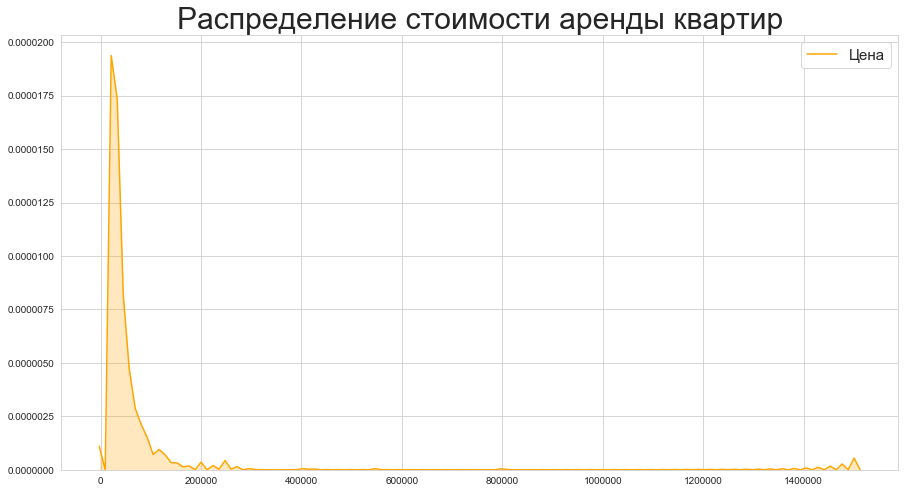

In [21]:
# Немного визуализации - распределение стоимости квартир
sns.kdeplot(data.price, shade = True, label = 'Цена', color = 'orange')
plt.title('Распределение стоимости аренды квартир', fontsize = 30)
plt.legend(fontsize = 15)
plt.show()

На графике год постройки 

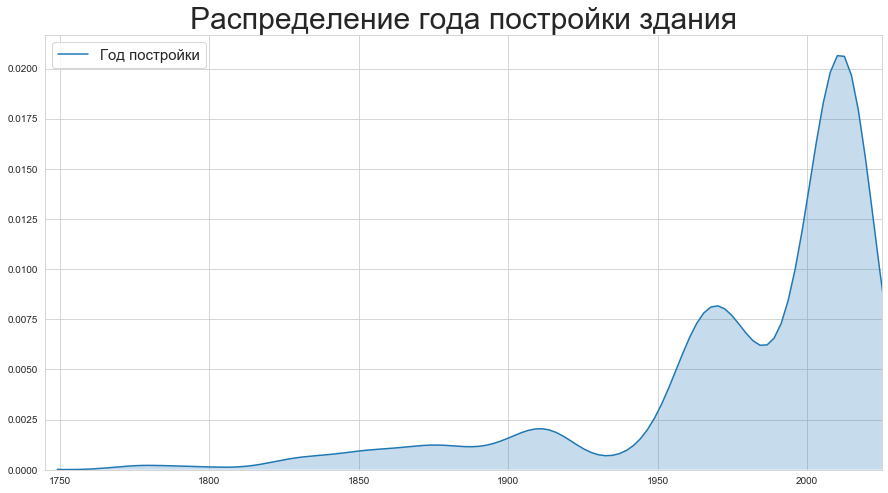

In [22]:
# распределение года постройки
sns.kdeplot(data['Год постройки'], shade = True, label = 'Год постройки')
plt.title('Распределение года постройки здания', fontsize = 30)
plt.legend(fontsize = 15)
plt.xlim(1745,2025)
plt.show()

Чем ближе находится метро, тем выше стоимость аренды. Также стоит отметить, что плотность признаков и расположение точек на линейном графике указывают на потенциальную логарифмическую зависимость.

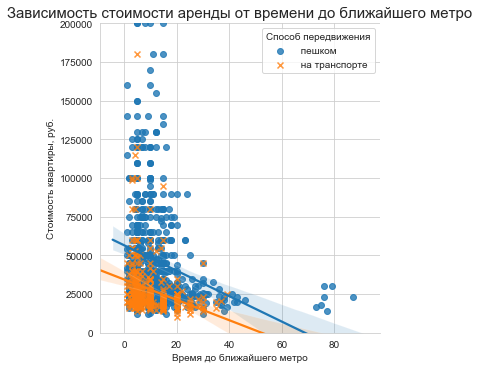

In [23]:
# Как на цену аренды влияет расстояние от метро? Посмотрим для квартир, где стоимость не превышает
# 200 000 рублей в месяц
sns.lmplot(x= 'time_to_metro', y = 'price', hue = 'move_type', data = data, legend = False, 
          markers=["o", "x"])
plt.title('Зависимость стоимости аренды от времени до ближайшего метро', fontsize = 15)
plt.xlabel('Время до ближайшего метро')
plt.ylabel('Стоимость квартиры, руб.')
plt.ylim(0,200000)
plt.legend(title = 'Cпособ передвижения')
plt.show()

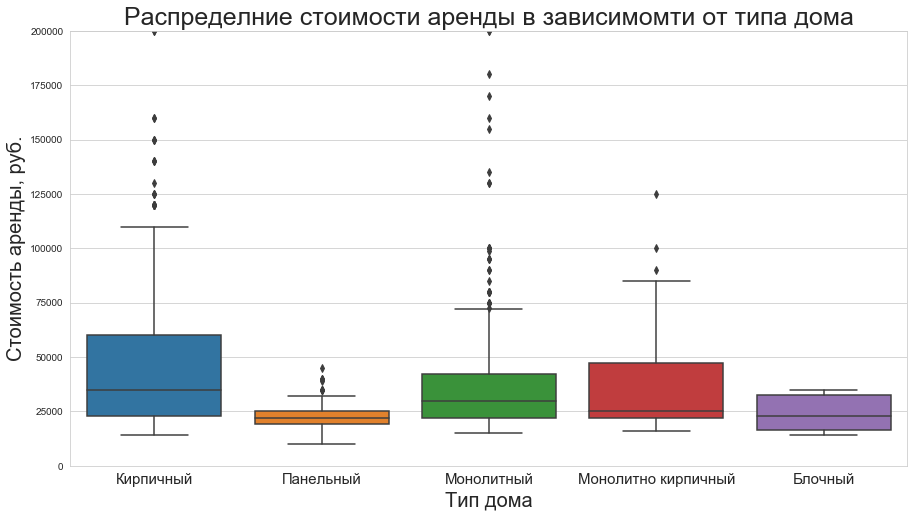

In [24]:
# Посмотрим стоимость в зависимости от типа дома. Смотрим с такими же ограничениями как и в
# на прошлом графике. 
sns.boxplot(x = 'Тип дома', y = 'price', data = data)
plt.title('Распределние стоимости аренды в зависимомти от типа дома', fontsize = 25)
plt.xlabel('Тип дома', fontsize = 20)
plt.ylabel('Стоимость аренды, руб.', fontsize = 20)
plt.ylim(0,200000)
plt.xticks(fontsize = 15)
plt.show()

In [25]:
# Сделаем визуализацию по районам на карте города. Посмотрим на среднюю стоимость квартиры и
# этажность зданий, где они сдаются, по районам Петербурга. Создаем вспомогательный датасет
spb_districts = pd.DataFrame(data.price.groupby(data.district).mean())
spb_districts['height'] = data.height.groupby(data.district).mean()
spb_districts

,price,height
district,,
р-н Адмиралтейский,52792.759036,8.710843
р-н Василеостровский,40715.831776,12.009346
р-н Выборгский,27880.952381,16.563492
р-н Калининский,22268.292683,13.341463
р-н Кировский,22729.145833,11.104167
р-н Колпинский,25000.000000,7.500000
р-н Красногвардейский,27734.482759,12.844828
р-н Красносельский,19539.130435,13.782609
р-н Кронштадтский,17000.000000,6.500000


In [26]:
with open('districts_spb.pickle', 'rb') as f: 
    shape_spb_shape = pickle.load(f)

In [27]:
# Упорядочиваем данные по районам
shape_spb_shape = shape_spb_shape.sort_values('name')
shape_spb_shape

,name,geometry
33,Адмиралтейский район,"POLYGON ((30.34275 59.91710, 30.34225 59.91691..."
19,Василеостровский район,"POLYGON ((30.31686 59.94566, 30.30989 59.94164..."
18,Выборгский район,"POLYGON ((30.38739 60.05918, 30.38565 60.05721..."
20,Калининский район,"POLYGON ((30.44217 59.99982, 30.43936 59.99719..."
31,Кировский район,"POLYGON ((30.30002 59.88269, 30.29967 59.88146..."
7,Колпинский район,"POLYGON ((30.75969 59.75417, 30.75958 59.75370..."
21,Красногвардейский район,"POLYGON ((30.56533 59.97092, 30.56477 59.97069..."
29,Красносельский район,"MULTIPOLYGON (((30.08271 59.67608, 30.07331 59..."
9,Кронштадтский район,"MULTIPOLYGON (((29.81382 59.98960, 29.81347 59..."
16,Курортный район,"POLYGON ((30.19531 60.11728, 30.19387 60.11730..."


In [28]:
# Объединяем данные
spb_districts_geo = gpd.GeoDataFrame(spb_districts)
spb_districts_geo['geometry'] = list(shape_spb_shape.geometry)

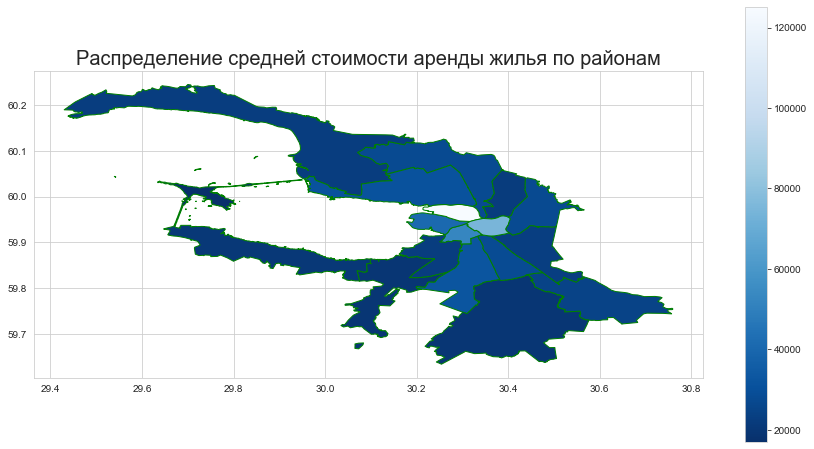

In [29]:
# Делаем график по распределению цены 
spb_districts_geo.plot(column = 'price', linewidth=1, cmap ='Blues_r' ,legend=True,  edgecolor = 'g')
plt.title('Распределение средней стоимости аренды жилья по районам', fontsize = 20)
plt.show()

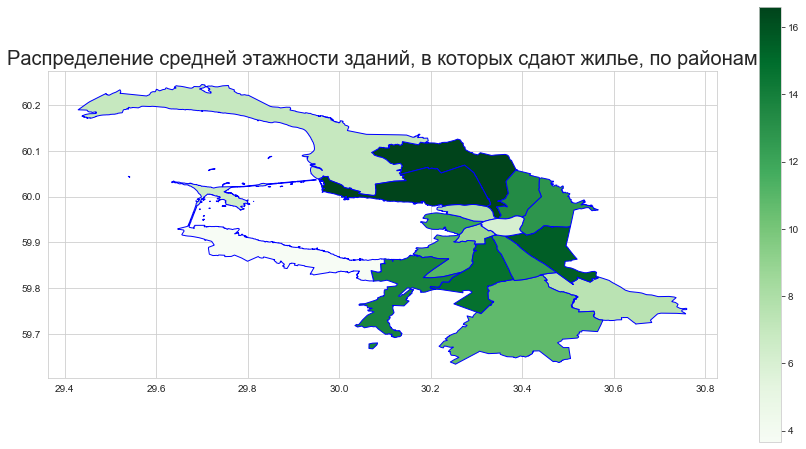

In [30]:
# А здесь - график по распределению этажности домов, в которых сдаются квартиры
spb_districts_geo.plot(column = 'height', linewidth = 1, cmap ='Greens' ,legend=True,  edgecolor = 'b')
plt.title('Распределение средней этажности зданий, в которых сдают жилье, по районам', fontsize = 20)
plt.show()

## Пропуски 

Почему мы посчитали допустимым заполнить эти пропуски нулями? В разделе "Общая информация" просто указываются эти предметы. Если нет информации, то либо этих предметов в квартире нет, либо автор объявления поленился их указать.

In [31]:
# Теперь сгенерируем бинарные переменные - заменим пропуски в данных на нули. Разумеется, в пределах
# допустимого. 
data['Холодильник'] = data['Холодильник'].fillna(0)
data['Стиральная машина'] = data['Стиральная машина'].fillna(0)
data['Посудомоечная машина'] = data['Стиральная машина'].fillna(0)
data['Мебель в комнатах'] = data['Мебель в комнатах'].fillna(0)
data['Мебель на кухне'] = data['Мебель на кухне'].fillna(0)
data['Интернет'] = data['Интернет'].fillna(0)
data['Телевизор'] = data['Телевизор'].fillna(0)
data['Можно с детьми'] = data['Можно с детьми'].fillna(0)
data['Ванна'] = data['Ванна'].fillna(0)
data['Душевая кабина'] = data['Душевая кабина'].fillna(0)
data['Кондиционер'] = data['Кондиционер'].fillna(0)
data['Можно с животными'] = data['Можно с животными'].fillna(0)

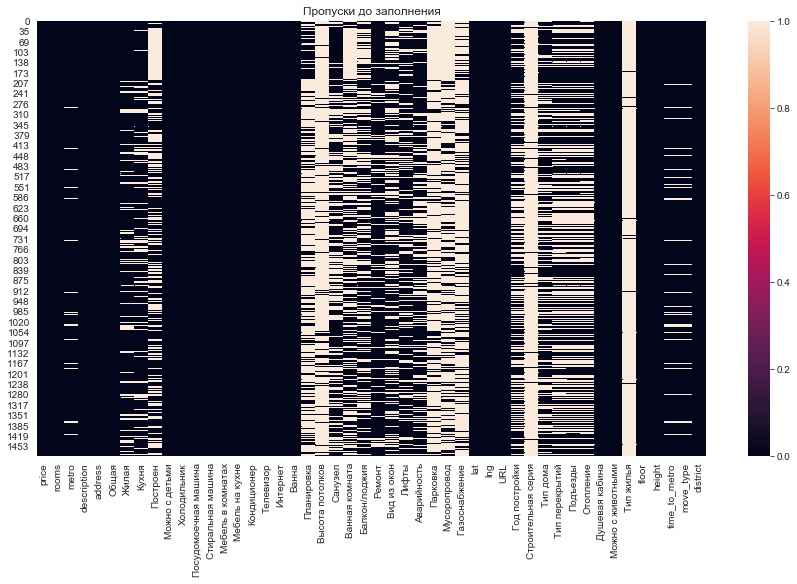

In [32]:
sns.heatmap(data.isna())
plt.title('Пропуски до заполнения');

### Тип жилья
Тип жилья -- апартаменты и так указан в переменной rooms, поэтому выбросим эту переменную.

In [33]:
data['Тип жилья'].value_counts()

Апартаменты    15
Name: Тип жилья, dtype: int64

In [34]:
data.drop('Тип жилья', axis = 1, inplace = True)

### Строительная серия 

Этит признак практически у всех наблюдений пропущен и, кажется, не несет особого смысла -- уберем его.

In [35]:
data['Строительная серия'].value_counts()

1-528КП    22
ЛГ-600     11
ОД          6
1ЛГ-504     5
1-507       4
И-155       4
1-510       3
111-121     2
1-527       1
1-405       1
1-335       1
Г-5         1
Name: Строительная серия, dtype: int64

In [36]:
data.drop('Строительная серия', axis = 1, inplace = True)

### Тип перекрытий, тип дома, подъезды 

In [37]:
data['Тип перекрытий'].value_counts()

Железобетонные    728
Смешанные         110
Деревянные         16
Name: Тип перекрытий, dtype: int64

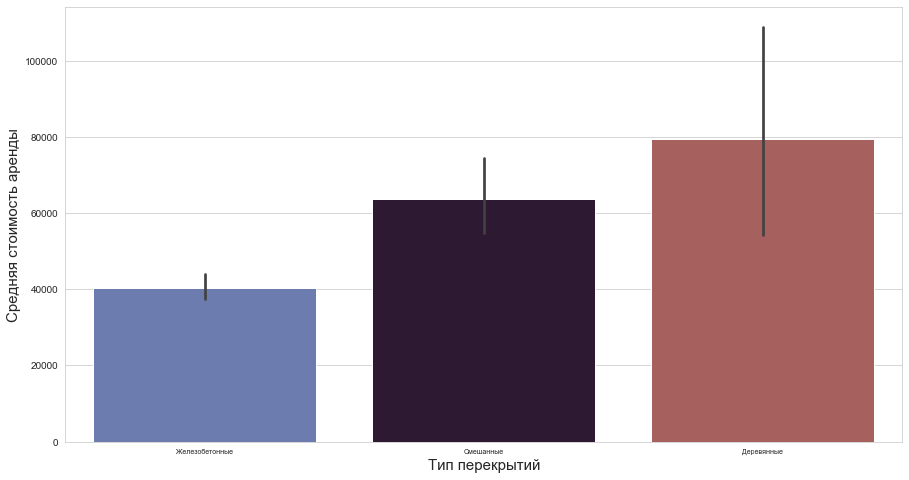

In [38]:
sns.barplot(x= 'Тип перекрытий', y = 'price', palette='twilight', data = data)
plt.xlabel('Тип перекрытий', fontsize = 15)
plt.xticks(fontsize = 7)
plt.ylabel('Средняя стоимость аренды', fontsize = 15)
plt.show()

In [39]:
data['Тип дома'].value_counts()

Кирпичный              385
Монолитный             384
Панельный              175
Монолитно кирпичный     35
Блочный                  6
Name: Тип дома, dtype: int64

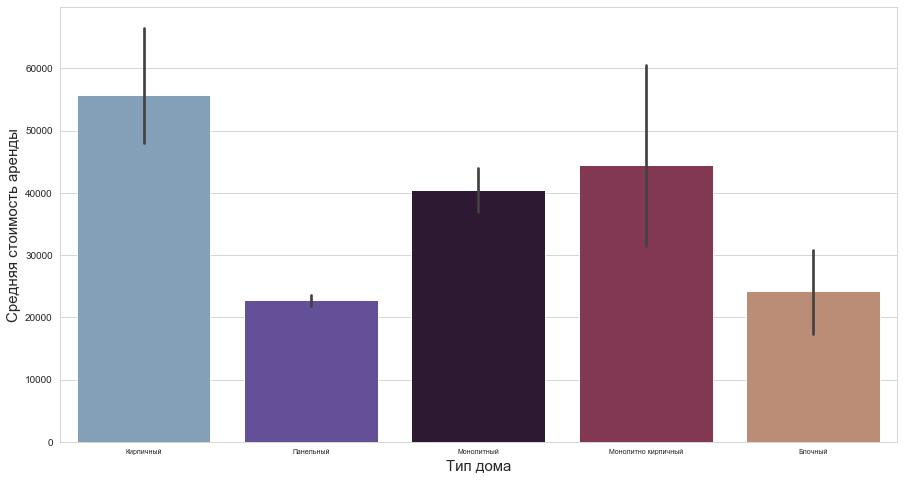

In [40]:
sns.barplot(x= 'Тип дома', y = 'price', palette='twilight', data = data)
plt.xlabel('Тип дома', fontsize = 15)
plt.xticks(fontsize = 7)
plt.ylabel('Средняя стоимость аренды', fontsize = 15)
plt.show()

In [41]:
data['Подъезды'].value_counts()

3.0     124
4.0     119
2.0     102
7.0      91
5.0      82
6.0      74
1.0      59
8.0      46
11.0     40
10.0     29
12.0     23
9.0      22
13.0     13
16.0     11
15.0      7
19.0      7
14.0      6
20.0      6
21.0      5
22.0      5
37.0      4
18.0      4
24.0      2
40.0      2
29.0      2
17.0      1
48.0      1
Name: Подъезды, dtype: int64

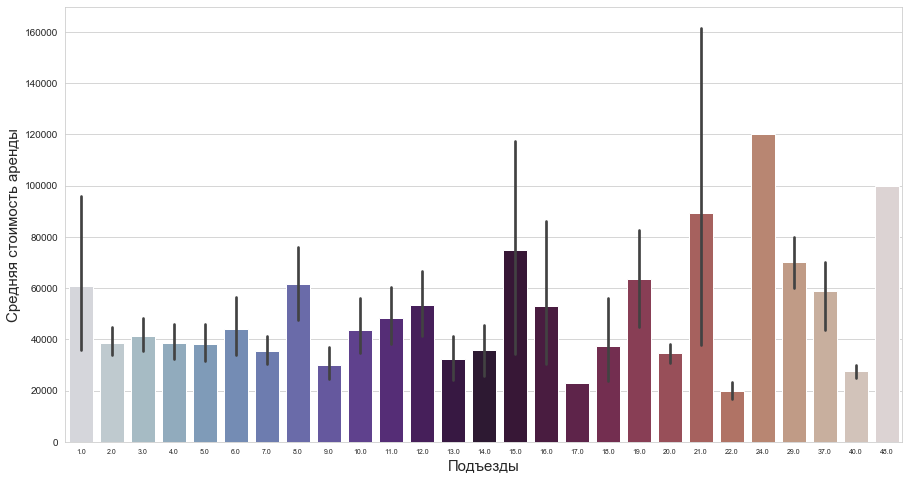

In [42]:
sns.barplot(x = 'Подъезды', y = 'price', palette='twilight', data = data)
plt.xlabel('Подъезды', fontsize = 15)
plt.xticks(fontsize = 7)
plt.ylabel('Средняя стоимость аренды', fontsize = 15)
plt.show()

In [43]:
data.drop('Подъезды', axis = 1, inplace = True)

### Газоснабжение, отопление, мусоропровод, аварийность

Для мусоропровода сосдадим две бинарные переменные: есть и нет.

Автономная котельная -- возможность включать отопление -- ценится многими, поэтому создадим бинарную переменную дл нее.

Мусоропровод не дает значимых различий на стоимость квартиры, поэтому не будем учитыват его в модели.

Аварийность -- ни о чем не говорящий признак. Просто то-то указал, кто-то нет. На графике видно, что между средней ценой для тех кто указал, и тех, кто не указал нет значимой разницы. Уберем этот признак

In [44]:
data['Газоснабжение'].value_counts()

Центральное    342
Автономное      12
Name: Газоснабжение, dtype: int64

In [45]:
data['Отопление'].value_counts()

Центральное                      779
Автономная котельная              50
Индивидуальный тепловой пункт     31
Name: Отопление, dtype: int64

In [46]:
data['boiler_room'] = data['Отопление'] == 'Автономная котельная'

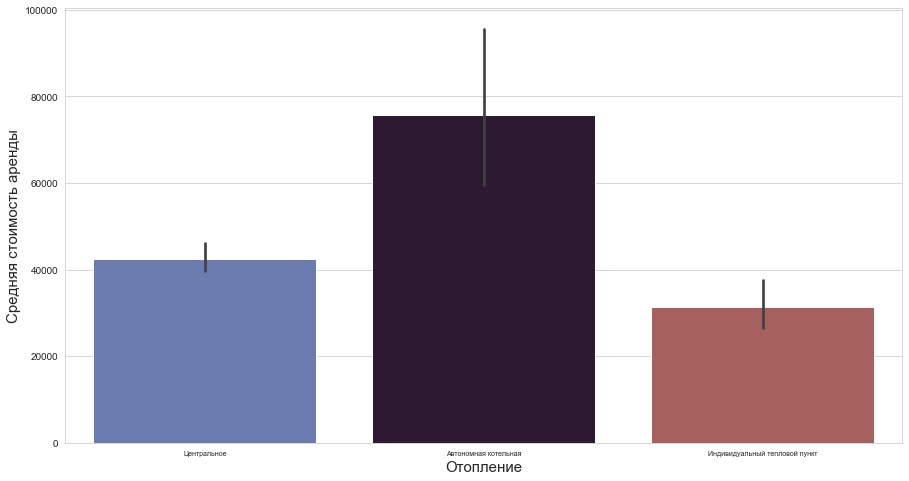

In [47]:
sns.barplot(x = 'Отопление', y = 'price', palette='twilight', data = data)
plt.xlabel('Отопление', fontsize = 15)
plt.xticks(fontsize = 7)
plt.ylabel('Средняя стоимость аренды', fontsize = 15)
plt.show()

In [48]:
data['Мусоропровод'].value_counts()

Есть    302
Нет     115
Name: Мусоропровод, dtype: int64

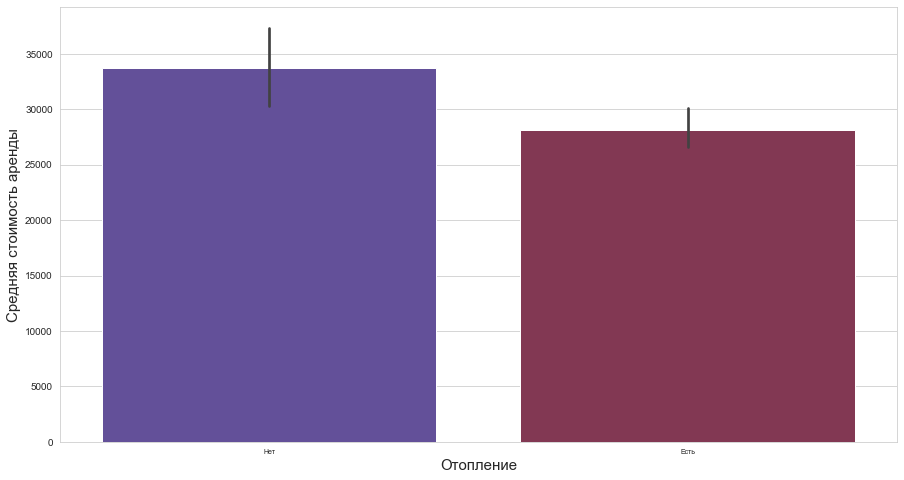

In [49]:
sns.barplot(x = 'Мусоропровод', y = 'price', palette='twilight', data = data)
plt.xlabel('Отопление', fontsize = 15)
plt.xticks(fontsize = 7)
plt.ylabel('Средняя стоимость аренды', fontsize = 15)
plt.show()

In [50]:
data['Аварийность'].value_counts()

Нет    1030
Name: Аварийность, dtype: int64

In [51]:
data['Аварийность'].fillna('Нет данных', inplace = True)

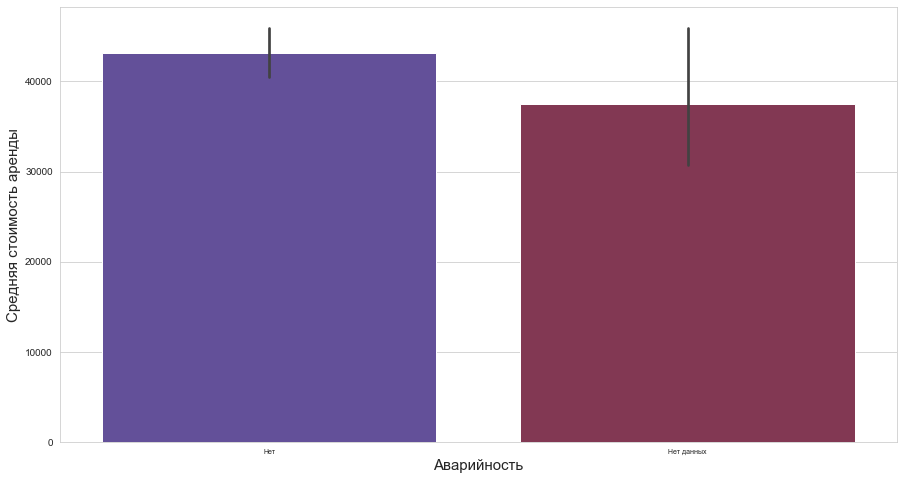

In [52]:
sns.barplot(x = 'Аварийность', y = 'price', palette='twilight', data = data)
plt.xlabel('Аварийность', fontsize = 15)
plt.xticks(fontsize = 7)
plt.ylabel('Средняя стоимость аренды', fontsize = 15)
plt.show()

In [53]:
data.drop('Аварийность', axis = 1, inplace = True)

### Лифты

Разница в ценах для квартир между разными "типами лифтов" незначимая.

Если создать новую переменную, которая будет отражать наличие информации / наличие лифта, то разница в ценах для таких квартир незначимая.

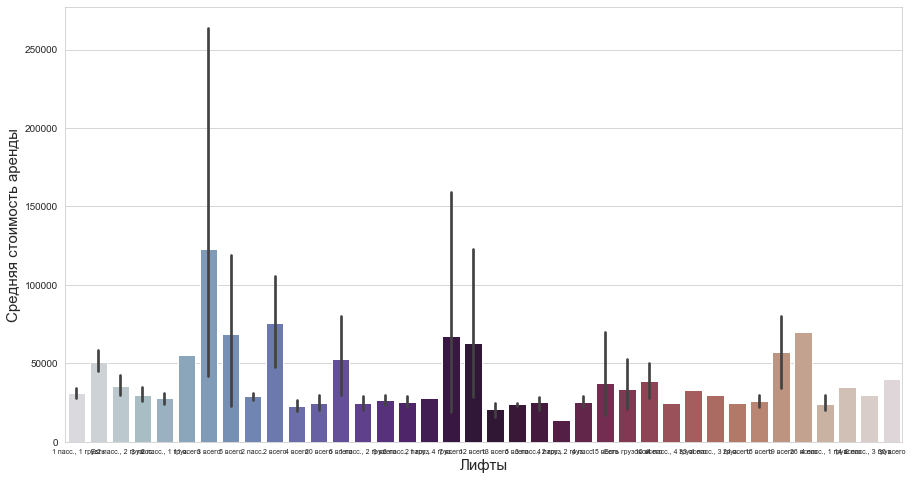

In [54]:
sns.barplot(x = 'Лифты', y = 'price', palette='twilight', data = data)
plt.xlabel('Лифты', fontsize = 15)
plt.xticks(fontsize = 7)
plt.ylabel('Средняя стоимость аренды', fontsize = 15)
plt.show()

In [55]:
data['elevator_available'] = ~data['Лифты'].isna()

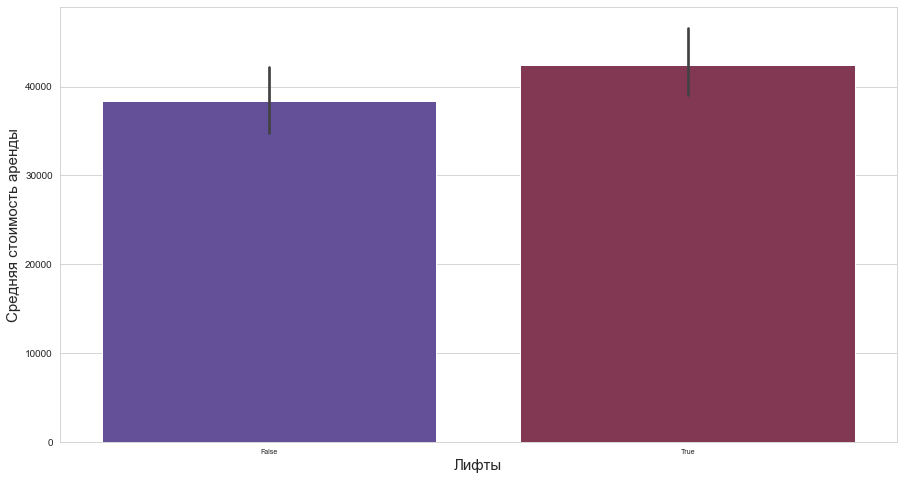

In [56]:
sns.barplot(x = 'elevator_available', y = 'price', palette='twilight', data = data)
plt.xlabel('Лифты', fontsize = 15)
plt.xticks(fontsize = 7)
plt.ylabel('Средняя стоимость аренды', fontsize = 15)
plt.show()

In [57]:
data.drop('Лифты', axis = 1, inplace = True)

### Метро и время до него

Есть наблюдения, в которых не указано ближайшее метро. Это не повод их удалять, так как в этом случае отсутсвие информации -- тоже информация.

Поступим с этими признаками так. 
1. создим новый бинарный признак, равный 1 в случае пропуска.
2. заменим пропуски на произвольную константу $ c $, которая среди других переменных не встречается.
3. Теперь, когда мы построим регрессию на оба признака и получим модель вида
$$ y=\beta_0 + \beta_1 x_1 + \beta_2 x_2 $$

на тех объектах, где $ x_1 $ было измерено, регрессионное уравнение примет вид
$$ y=\beta_0 + \beta_1 x, $$

а там, где $ x_1 $ было не измерено, получится
$ y=\beta_0 + \beta_1 c + \beta_2. $

Выбор $ c $ влияет только на значение и интерпретацию $ \beta_2 $, но не $ \beta_1 $.

In [58]:
data.head()

,price,rooms,metro,description,address,Общая,Жилая,Кухня,Построен,Можно с детьми,Холодильник,Посудомоечная машина,Стиральная машина,Мебель в комнатах,Мебель на кухне,Кондиционер,Телевизор,Интернет,Ванна,Планировка,Высота потолков,Санузел,Ванная комната,Балкон/лоджия,Ремонт,Вид из окон,Парковка,Мусоропровод,Газоснабжение,lat,lng,URL,Год постройки,Тип дома,Тип перекрытий,Отопление,Душевая кабина,Можно с животными,floor,height,time_to_metro,move_type,district,boiler_room,elevator_available
0,37000.0,2-комн. квартира,Ленинский проспект,Сдаётся квартира на длительный период в 10 мин...,"Санкт-Петербург, р-н Кировский, Княжево, просп...",44.1,23.0,9.0,2013.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Смежно-изолированная,"2,8 м",1 раздельный,Есть,"1 балкон, 1 лоджия",Дизайнерский,На улицу,Наземная,Нет,Автономное,59.850952,30.281418,https://spb.cian.ru/rent/flat/246712086/,NaN,NaN,NaN,NaN,0.0,0.0,4.0,21.0,11.0,пешком,р-н Кировский,False,True
1,14000.0,1-комн. квартира,NaN,"Сдается на длительный срок 1 комн. квартира, п...","Санкт-Петербург, р-н Красносельский, мкр. Крас...",33.0,18.0,7.0,1975.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,1 совмещенный,Есть,1 балкон,Косметический,Во двор,NaN,Есть,Центральное,59.721511,30.076242,https://spb.cian.ru/rent/flat/246711397/,1975.0,Кирпичный,Железобетонные,Центральное,0.0,0.0,6.0,9.0,NaN,NaN,р-н Красносельский,False,True
2,25000.0,2-комн. квартира,Пионерская,"Сдается 2х комнатная квартира, от собственника...","Санкт-Петербург, р-н Приморский, Комендантский...",44.7,27.0,6.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Изолированная,NaN,1 раздельный,Есть,1 лоджия,Косметический,Во двор,NaN,Есть,NaN,60.006345,30.278911,https://spb.cian.ru/rent/flat/246711314/,NaN,NaN,NaN,NaN,0.0,0.0,4.0,9.0,15.0,пешком,р-н Приморский,False,True
3,20000.0,1-комн. квартира,Звездная,"Сдается на долгий срок, светлая и теплая кварт...","Санкт-Петербург, р-н Московский, Звёздное, про...",35.0,15.4,9.6,2019.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,1 совмещенный,NaN,1 лоджия,Евроремонт,На улицу,Наземная,NaN,NaN,59.819382,30.340976,https://spb.cian.ru/rent/flat/246709991/,2019.0,NaN,Железобетонные,NaN,1.0,0.0,14.0,18.0,25.0,пешком,р-н Московский,False,True
4,22000.0,Студия,Удельная,"EMLS ID 369220. Высокий первый этаж, отличный ...","Санкт-Петербург, р-н Выборгский, Светлановское...",22.0,14.0,3.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,Евроремонт,Во двор,NaN,NaN,NaN,60.007645,30.323037,https://spb.cian.ru/rent/flat/246709436/,NaN,NaN,NaN,NaN,1.0,1.0,1.0,5.0,10.0,пешком,р-н Выборгский,False,True


In [59]:
# заполним пропуски
data['no_metro'] = data.metro.isna()
data.time_to_metro.fillna(-1, inplace=True)

# создадим бинарную переменную
data['afoot'] = data.move_type == ' пешком'

### Ремонт

Как видно из графика, наличие дизайнрского приводит к значимому увеличению стоимости аренды. Создадим бинарную переменную для этого типа ремонта.

In [60]:
data['Ремонт'].fillna('Нет данных', inplace = True)

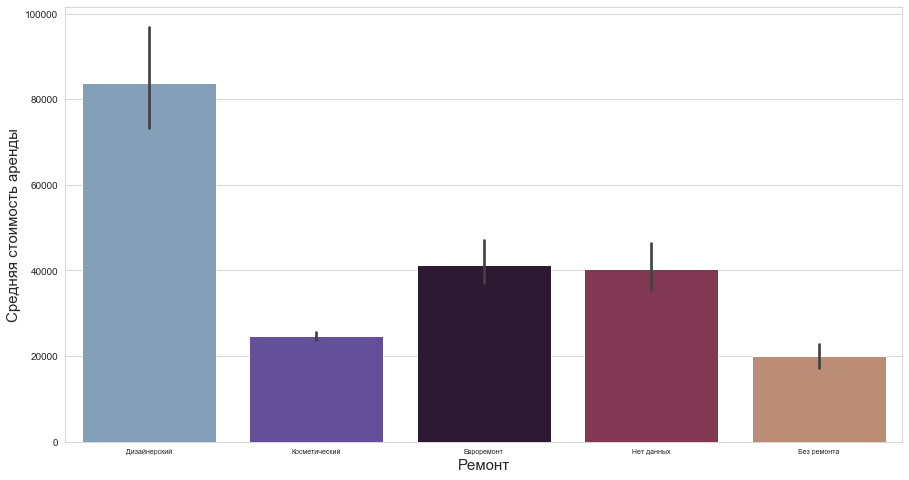

In [61]:
sns.barplot(x = 'Ремонт', y = 'price', palette='twilight', data = data)
plt.xlabel('Ремонт', fontsize = 15)
plt.xticks(fontsize = 7)
plt.ylabel('Средняя стоимость аренды', fontsize = 15)
plt.show()

In [62]:
data['designer'] = data['Ремонт'] == 'Дизайнерский'

### Балкон / лождия, вид из окна

In [63]:
data['Вид из окон'].fillna('Нет данных', inplace = True)

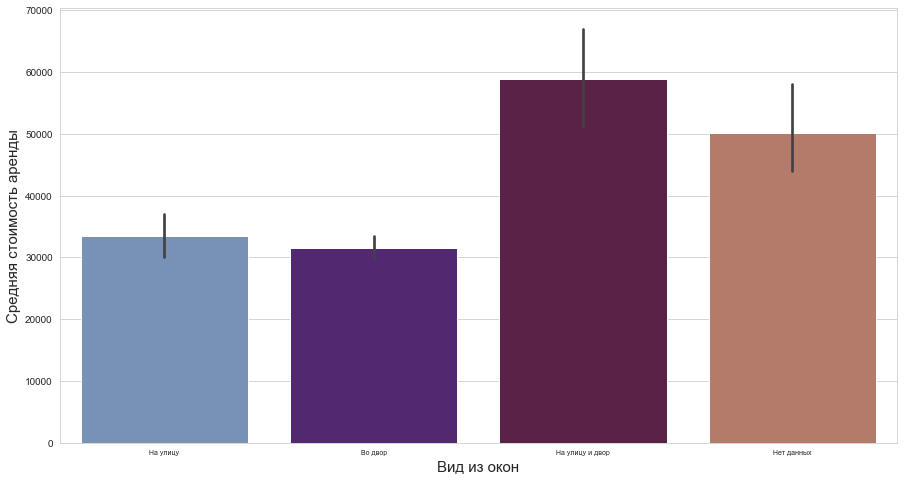

In [64]:
sns.barplot(x = 'Вид из окон', y = 'price', palette='twilight', data = data)
plt.xlabel('Вид из окон', fontsize = 15)
plt.xticks(fontsize = 7)
plt.ylabel('Средняя стоимость аренды', fontsize = 15)
plt.show()

### Парковка

In [65]:
def custom_barplot(variable):
    sns.barplot(x = variable, y = 'price', palette='twilight', data = data)
    plt.xlabel(variable, fontsize = 15)
    plt.xticks(fontsize = 7)
    plt.ylabel('Средняя стоимость аренды', fontsize = 15)
    plt.show()

In [66]:
data['Парковка'].fillna('Нет данных', inplace = True)

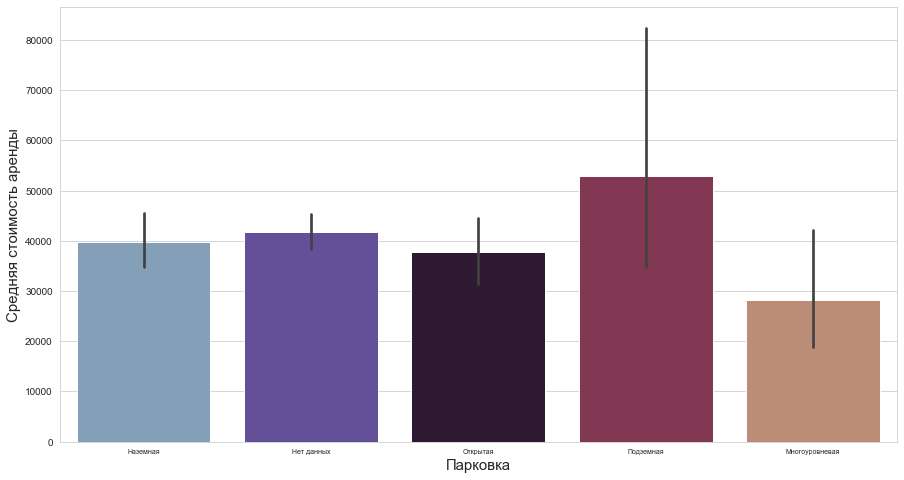

In [67]:
custom_barplot('Парковка')

### Высота потолков 
Какой-то зависимости между высотой потолков и ценой не наблюдается. Кроме того -- это признак отсуствует для большинства квартир. Исключим его.

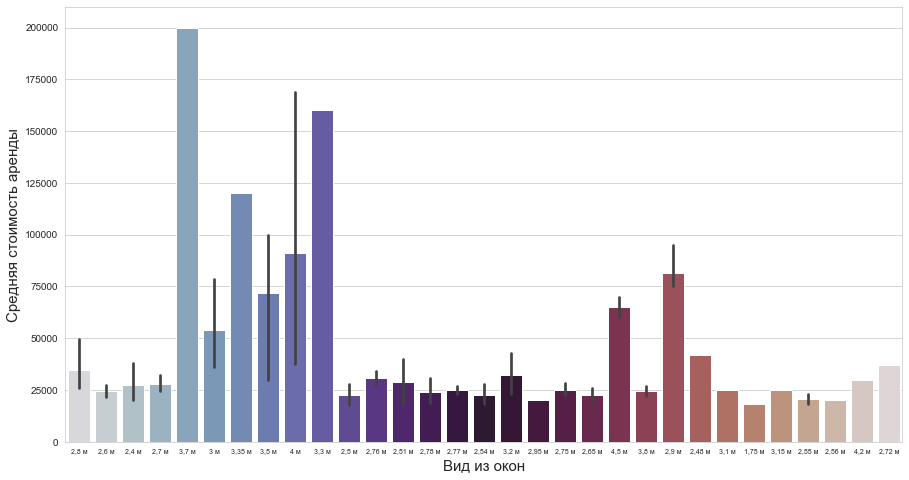

In [68]:
sns.barplot(x = 'Высота потолков', y = 'price', palette='twilight', data = data)
plt.xlabel('Вид из окон', fontsize = 15)
plt.xticks(fontsize = 7)
plt.ylabel('Средняя стоимость аренды', fontsize = 15)
plt.show()

In [69]:
data.drop('Высота потолков', axis = 1, inplace = True)

### Тип дома

In [70]:
data['brick'] = data['Тип дома'] == 'Кирпичный'
data['panel'] = data['Тип дома'] == 'Панельный'
data['monolithic'] = (data['Тип дома'] == 'Монолитный')| (data['Тип дома'] == 'Монолитно-кирпичный')
data['block'] = data['Тип дома'] == 'Блочный'

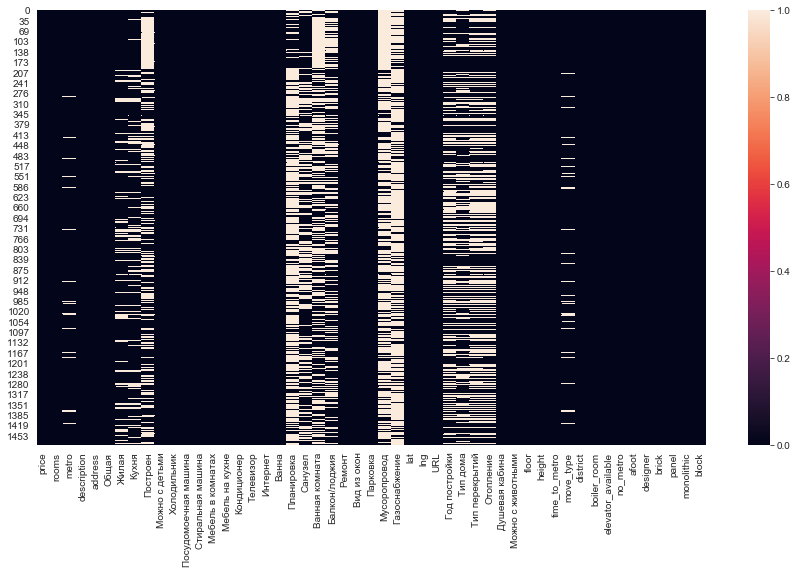

In [71]:
# Вновь посмотрим на пропуски в данных 
sns.heatmap(data.isna());

### Комнатность

In [72]:
data.rooms.value_counts()

1-комн. квартира           573
2-комн. квартира           422
Студия                     189
3-комн. квартира           177
4-комн. квартира            40
Апартаменты-студия          10
5-комн. квартира             7
1-комн. апартаменты          3
Многокомнатная квартира      2
3-комн. апартаменты          1
2-комн. апартаменты          1
Name: rooms, dtype: int64

In [73]:
# преобразуем rooms, чтобы можно было посчитать vif
data['one_room'] = (data.rooms == '1-комн. квартира') | (data.rooms == '1-комн. апартаменты')
data['two_rooms'] = (data.rooms == '2-комн. квартира') | (data.rooms == '2-комн. апартаменты')
data['three_rooms'] = (data.rooms == '3-комн. квартира') | (data.rooms == '3-комн. апартаменты')
data['studio'] = (data.rooms == 'Студия') | (data.rooms == 'Апартаменты-студия')

### Переименование столбцов

In [74]:
# финальный этап очистки: переимнование столбцов
data.rename(columns={'Общая':'total', 
                     'Жилая':'living', 
                     'Кухня':'kitchen',
                    'Построен':'built',
                    'Можно с детьми':'kids_allowed',
                    'Холодильник':'fridge',
                    'Посудомоечная машина':'dishwasher',
                    'Стиральная машина':'washer', 
                    'Мебель в комнатах':'furniture_rooms',
                    'Мебель на кухне':'furniture_kitchen',
                    'Телевизор':'tv',
                    'Кондиционер':'conditioner',
                    'Интернет':'internet',
                    'Ванна':'bath', 
                    'Санузел':'bathroom',
                    'Балкон/лоджия':'balcony',
                    'Ремонт':'renovation', 
                    'Вид из окон': 'view', 
                    'Тип дома':'building_type',
                    'Душевая кабина':'shower_cabin', 
                    'Можно с животными':'animals_allowed', 
                    'Тип жилья': 'housing_type',
                    'Строительная серия': 'construction_series',
                    'Тип перекрытий': 'floor_type', 
                    'Подъезды': 'entrances',
                    'Отопление': 'heating', 
                    'Газоснабжение': 'gas',
                    'Год постройки': 'year_built',
                    'Лифты': 'elevators', 
                    'Аварийность': 'emergency', 
                    'Парковка': 'parking', 
                    'Мусоропровод': 'garbage_chute', 
                    'Планировка': 'layout'}, inplace=True)

## Корреляционная матрица

Цена коррелирована с обшей площадью, жилой площадью и площадью кухни. При этом последние три признака коррелированы между собой. Это может привести в мультиколинеарности и несостоятельности оценок. Также площадь коррелирует с количеством комнат.

Из всех признаков, связанных с наличием мебели и техники, наибольшая корреляция с ценой у телевизора и интернета.

Наличие мебели на кухне, стиральная машина и холодильник коррелированы между собой.

Были собраны данные "год постройки" и "построен". Один из них видимо указывался арендодателем, а второй брался из данных Циан (поэтому и корреляция 0,99, а не 1!). Будем исполььзовать только один их этих признаков для построения моделей.

Такие характеристики, как этажность, год постройки и высота потолков также коррелированы между собой.

Этажность и "можно с животными" также коррелированы между собой. Эту взаимосвязь неочевидна. 

Вомжно, что некоторые корреляции возникли из-за того, что некоторые пользователи подробно указывали данные о жилье, а некоторые оставили этот раздел пустым.

In [75]:
data.drop('dishwasher', axis=1).corr(method='pearson').style.format("{:.2}").background_gradient(cmap='BuPu', axis=1)

### Метро и время до него

После построения корреляционных матриц, заполним оставшиеся пропуски.

Есть наблюдения, в которых не указано ближайшее метро. Это не повод их удалять, так как в этом случае отсутсвие информации -- тоже информация.

Поступим с этими признаками так. 
1. создим новый бинарный признак, равный 1 в случае пропуска.
2. заменим пропуски на произвольную константу $ c $, которая среди других переменных не встречается.
3. Теперь, когда мы построим регрессию на оба признака и получим модель вида
$$ y=\beta_0 + \beta_1 x_1 + \beta_2 x_2 $$

на тех объектах, где $ x_1 $ было измерено, регрессионное уравнение примет вид
$$ y=\beta_0 + \beta_1 x, $$

а там, где $ x_1 $ было не измерено, получится
$ y=\beta_0 + \beta_1 c + \beta_2. $

Выбор $ c $ влияет только на значение и интерпретацию $ \beta_2 $, но не $ \beta_1 $.

In [76]:
data.head()

,price,rooms,metro,description,address,total,living,kitchen,built,kids_allowed,fridge,dishwasher,washer,furniture_rooms,furniture_kitchen,conditioner,tv,internet,bath,layout,bathroom,Ванная комната,balcony,renovation,view,parking,garbage_chute,gas,lat,lng,URL,year_built,building_type,floor_type,heating,shower_cabin,animals_allowed,floor,height,time_to_metro,move_type,district,boiler_room,elevator_available,no_metro,afoot,designer,brick,panel,monolithic,block,one_room,two_rooms,three_rooms,studio
0,37000.0,2-комн. квартира,Ленинский проспект,Сдаётся квартира на длительный период в 10 мин...,"Санкт-Петербург, р-н Кировский, Княжево, просп...",44.1,23.0,9.0,2013.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Смежно-изолированная,1 раздельный,Есть,"1 балкон, 1 лоджия",Дизайнерский,На улицу,Наземная,Нет,Автономное,59.850952,30.281418,https://spb.cian.ru/rent/flat/246712086/,NaN,NaN,NaN,NaN,0.0,0.0,4.0,21.0,11.0,пешком,р-н Кировский,False,True,False,True,True,False,False,False,False,False,True,False,False
1,14000.0,1-комн. квартира,NaN,"Сдается на длительный срок 1 комн. квартира, п...","Санкт-Петербург, р-н Красносельский, мкр. Крас...",33.0,18.0,7.0,1975.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1 совмещенный,Есть,1 балкон,Косметический,Во двор,Нет данных,Есть,Центральное,59.721511,30.076242,https://spb.cian.ru/rent/flat/246711397/,1975.0,Кирпичный,Железобетонные,Центральное,0.0,0.0,6.0,9.0,-1.0,NaN,р-н Красносельский,False,True,True,False,False,True,False,False,False,True,False,False,False
2,25000.0,2-комн. квартира,Пионерская,"Сдается 2х комнатная квартира, от собственника...","Санкт-Петербург, р-н Приморский, Комендантский...",44.7,27.0,6.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Изолированная,1 раздельный,Есть,1 лоджия,Косметический,Во двор,Нет данных,Есть,NaN,60.006345,30.278911,https://spb.cian.ru/rent/flat/246711314/,NaN,NaN,NaN,NaN,0.0,0.0,4.0,9.0,15.0,пешком,р-н Приморский,False,True,False,True,False,False,False,False,False,False,True,False,False
3,20000.0,1-комн. квартира,Звездная,"Сдается на долгий срок, светлая и теплая кварт...","Санкт-Петербург, р-н Московский, Звёздное, про...",35.0,15.4,9.6,2019.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,1 совмещенный,NaN,1 лоджия,Евроремонт,На улицу,Наземная,NaN,NaN,59.819382,30.340976,https://spb.cian.ru/rent/flat/246709991/,2019.0,NaN,Железобетонные,NaN,1.0,0.0,14.0,18.0,25.0,пешком,р-н Московский,False,True,False,True,False,False,False,False,False,True,False,False,False
4,22000.0,Студия,Удельная,"EMLS ID 369220. Высокий первый этаж, отличный ...","Санкт-Петербург, р-н Выборгский, Светлановское...",22.0,14.0,3.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,Евроремонт,Во двор,Нет данных,NaN,NaN,60.007645,30.323037,https://spb.cian.ru/rent/flat/246709436/,NaN,NaN,NaN,NaN,1.0,1.0,1.0,5.0,10.0,пешком,р-н Выборгский,False,True,False,True,False,False,False,False,False,False,False,False,True


In [77]:
# заполним пропуски
data['no_metro'] = data.metro.isna()
data.time_to_metro.fillna(-1, inplace=True)

# создадим бинарную переменную
data['afoot'] = data.move_type == ' пешком'

# Модели

Для выявления факторов, влияющих на стоимость аренды, мы решили использовать обычные OLS-регрессии, так как 
* результаты оценок можно легко интерпретировать
* в отличие от LASSO и Ridge-регрессий, OLS дает несмещенные оценки

In [78]:
from statsmodels.iolib.summary2 import summary_col 

In [79]:
data.dtypes

price                 float64
rooms                  object
metro                  object
description            object
address                object
total                 float64
living                float64
kitchen               float64
built                 float64
kids_allowed          float64
fridge                float64
dishwasher            float64
washer                float64
furniture_rooms       float64
furniture_kitchen     float64
conditioner           float64
tv                    float64
internet              float64
bath                  float64
layout                 object
bathroom               object
Ванная комната         object
balcony                object
renovation             object
view                   object
parking                object
garbage_chute          object
gas                    object
lat                   float64
lng                   float64
URL                    object
year_built            float64
building_type          object
floor_type

In [80]:
data.price.dtype == float

True

In [81]:
for col in data.columns:
    if data[col].dtype == bool:
        data[col] = data[col].astype(float)

In [82]:
numeric_columns = []

for col in data.drop(['price', 'lat', 'lng'], axis=1).columns:
    if data[col].dtype == float:
        if data[col].isna().sum() == 0:
            numeric_columns.append(col)

In [83]:
numeric_columns

['total',
 'kids_allowed',
 'fridge',
 'dishwasher',
 'washer',
 'furniture_rooms',
 'furniture_kitchen',
 'conditioner',
 'tv',
 'internet',
 'bath',
 'shower_cabin',
 'animals_allowed',
 'floor',
 'height',
 'time_to_metro',
 'boiler_room',
 'elevator_available',
 'no_metro',
 'afoot',
 'designer',
 'brick',
 'panel',
 'monolithic',
 'block',
 'one_room',
 'two_rooms',
 'three_rooms',
 'studio']

In [84]:
all_covarites = ['total', 'rooms', 'kids_allowed', 'fridge', 'dishwasher', 'washer', 'furniture_rooms', 
                 'furniture_kitchen', 'conditioner', 'tv', 'internet', 'bath', 'view', 'parking',
                'shower_cabin', 'animals_allowed', 'floor', 'height', 'district', 'elevator_available', 'designer', 
                'afoot', 'time_to_metro', 'no_metro']

## Variance Inflation Factor 

Показатель VIF больше 10 говорит о наличии мультиколлинеаности. 
* Исключим переменные "обстановки".
* Уберем количество комнат, так как оно сильно коррелирует с общей площадью
* Исключим наличие лифта: он коррелирует с этажностью. Информация о лифтах не была заполнена во многих объялениях, плюс наличие лифтов регулируется правилами, связанными с этажностью. 
* Исключим этаж.

In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [86]:
X = data[numeric_columns].values

vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

vif = pd.Series(vif, index=numeric_columns).round(2)
vif

C:\Users\79150\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


total                  4.80
kids_allowed           3.85
fridge                36.09
dishwasher              inf
washer                  inf
furniture_rooms       18.45
furniture_kitchen     16.31
conditioner            1.16
tv                     4.21
internet               4.64
bath                   3.07
shower_cabin           1.66
animals_allowed        1.84
floor                  4.76
height                10.14
time_to_metro          2.86
boiler_room            1.11
elevator_available     6.07
no_metro               1.22
afoot                  3.79
designer               1.40
brick                  2.12
panel                  1.48
monolithic             2.06
block                  1.04
one_room               9.79
two_rooms              6.22
three_rooms            3.08
studio                 4.51
dtype: float64

In [87]:
print(numeric_columns)

['total', 'kids_allowed', 'fridge', 'dishwasher', 'washer', 'furniture_rooms', 'furniture_kitchen', 'conditioner', 'tv', 'internet', 'bath', 'shower_cabin', 'animals_allowed', 'floor', 'height', 'time_to_metro', 'boiler_room', 'elevator_available', 'no_metro', 'afoot', 'designer', 'brick', 'panel', 'monolithic', 'block', 'one_room', 'two_rooms', 'three_rooms', 'studio']


In [88]:
columns_2 = ['total', 'kids_allowed', 'one_room', 'two_rooms', 'three_rooms', 'studio',
              'conditioner', 'tv', 'internet', 
             'bath', 'shower_cabin', 'animals_allowed', 'height', 
             'time_to_metro', 'boiler_room', 'no_metro', 'afoot', 
             'designer', 'brick', 'panel', 'monolithic', 'block']

In [89]:
X = data[columns_2].values

vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

vif = pd.Series(vif, index=columns_2).round(2)
vif

total              4.08
kids_allowed       3.82
one_room           6.71
two_rooms          4.55
three_rooms        2.53
studio             3.21
conditioner        1.15
tv                 3.82
internet           4.46
bath               3.00
shower_cabin       1.63
animals_allowed    1.83
height             6.16
time_to_metro      2.85
boiler_room        1.11
no_metro           1.21
afoot              3.68
designer           1.39
brick              2.10
panel              1.43
monolithic         2.00
block              1.03
dtype: float64

## Базовая модель, все признаки

In [90]:
data.columns

Index(['price', 'rooms', 'metro', 'description', 'address', 'total', 'living', 'kitchen', 'built', 'kids_allowed', 'fridge', 'dishwasher', 'washer', 'furniture_rooms', 'furniture_kitchen', 'conditioner', 'tv', 'internet', 'bath', 'layout', 'bathroom', 'Ванная комната', 'balcony', 'renovation', 'view', 'parking', 'garbage_chute', 'gas', 'lat', 'lng', 'URL', 'year_built', 'building_type', 'floor_type', 'heating', 'shower_cabin', 'animals_allowed', 'floor', 'height', 'time_to_metro', 'move_type', 'district', 'boiler_room', 'elevator_available', 'no_metro', 'afoot', 'designer', 'brick', 'panel', 'monolithic', 'block', 'one_room', 'two_rooms', 'three_rooms', 'studio'], dtype='object')

In [91]:
# Можем приступать к опредению факторов, влияющих на ценнобразование
# Начнем с простого - сделаем линейную регрессию цены на общую плошадь, количество комнат, времени 
# до метро, года постройки и этажности здания
model_baseline = smf.ols('np.log(price) ~ 1 + district + ' + ' + '.join(columns_2), 
                         data=data).fit(cov_type='HC0')
print(model_baseline.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     164.6
Date:                Fri, 11 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:44:44   Log-Likelihood:                 9.2046
No. Observations:                1425   AIC:                             61.59
Df Residuals:                    1385   BIC:                             272.1
Df Model:                          39                                         
Covariance Type:                  HC0                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

Видим, что незначимым оказались переменные 
1. категориальные для rooms.
2. блочный дом

In [92]:
df = model_baseline.pvalues 
df[df > 0.05]

kids_allowed    0.095201
three_rooms     0.303865
block           0.370012
dtype: float64

In [93]:
second_model = ['total', 'one_room', 'two_rooms',  'studio',
              'conditioner', 'tv', 'internet', 
             'bath', 'shower_cabin', 'animals_allowed', 'height', 
             'time_to_metro', 'boiler_room', 'no_metro', 'afoot', 
             'designer', 'brick', 'panel', 'monolithic']

In [94]:
model_2 = smf.ols('np.log(price) ~ 1 + district + ' + ' + '.join(second_model), 
                         data=data).fit(cov_type='HC0')
print(model_baseline.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(price)   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     164.6
Date:                Fri, 11 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:44:44   Log-Likelihood:                 9.2046
No. Observations:                1425   AIC:                             61.59
Df Residuals:                    1385   BIC:                             272.1
Df Model:                          39                                         
Covariance Type:                  HC0                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [95]:
df = model_2.pvalues 
df[df > 0.05]

Series([], dtype: float64)

In [96]:
from statsmodels.iolib.summary2 import summary_col 

info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}", 
'R-adj' : lambda x: f"{x.rsquared_adj:.2f}",
'No. observations' : lambda x: f"{int(x.nobs):d}"} 

results_table = summary_col(results=[model_baseline, model_2], 
float_format='%0.2f', 
stars = True, 
model_names = ['Модель 1', 'Модель 2'], 
info_dict=info_dict, 
# regressor_order=[]
                           ) 

results_table.add_title('OLS Regressions')

In [97]:
results_table

,Модель 1,Модель 2
Intercept,10.60***,10.46***
,(0.21),(0.11)
afoot,0.05***,0.05***
,(0.02),(0.02)
animals_allowed,-0.06***,-0.06***
,(0.01),(0.01)
bath,-0.09***,-0.10***
,(0.02),(0.02)
block,-0.07,
,(0.08),
